In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rasterstats import point_query
from shapely import wkt

In [5]:
points_df = pd.read_csv("/content/drive/MyDrive/data_set/fire/merged/combined_fire_nonfire.csv")

# Convertir la colonne 'geometry' qui est en WKT en objets shapely
points_df['geometry'] = points_df['geometry'].apply(wkt.loads)

# Créer le GeoDataFrame
points_gdf = gpd.GeoDataFrame(points_df, geometry='geometry', crs="EPSG:4326")

# Vérifier
print(points_gdf.head())
print(points_gdf.crs)

                   geometry  fire
0  POINT (5.53337 35.70751)     1
1   POINT (2.46763 36.4938)     1
2  POINT (2.47313 36.49316)     1
3  POINT (2.46726 36.49249)     1
4  POINT (2.47275 36.49182)     1
EPSG:4326


In [6]:
# =========================
# 2. Charger les données vectorielles
# =========================
land_cover = gpd.read_file("/content/drive/MyDrive/data_set/landcover/land_cover_dzd_tun")
soil = gpd.read_file("/content/drive/MyDrive/data_set/soil_type/shapefiles/clean/cleaned_soil.shp")
# Reprojection pour correspondre aux points
land_cover = land_cover.to_crs(points_gdf.crs)
soil = soil.to_crs(points_gdf.crs)


In [7]:
# =========================
# 3. Intersection spatiale Land cover & Soil
# =========================
land_soil_intersection = gpd.overlay(land_cover, soil, how='intersection')

# =========================
# 4. Affecter les attributs vectoriels aux points
# =========================
points_with_vector = gpd.sjoin(points_gdf, land_soil_intersection, how='left', predicate='intersects')

In [9]:
# =========================
# 5. Extraire les valeurs raster pour chaque point
# =========================
rasters = {
    "climat": "/content/drive/MyDrive/data_set/climate/algeria_tunisia_climate/output_saisons/saisons_12bandes.tif",
    "elevation": "/content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_elevation.tif",
    "aspect": "/content/drive/MyDrive/data_set/Elevation/cleaned/cleaned_aspect.tif",
    "NDVI": "/content/drive/MyDrive/data_set/NDVI/NDVI.tif"
}

for feature_name, raster_path in rasters.items():
    points_with_vector[feature_name] = point_query(points_with_vector.geometry, raster_path, interpolate='nearest')

# =========================
# 6. Nettoyer et sauvegarder
# =========================
# Supprimer colonne inutile générée par sjoin
points_with_vector.drop(columns='index_right', errors='ignore', inplace=True)

# Sauvegarde CSV
points_with_vector.to_csv("/content/drive/MyDrive/data_set/merge/points_with_features.csv", index=False)

print("✅ Processus terminé, points avec toutes les caractéristiques sauvegardés.")


/usr/local/lib/python3.12/dist-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


✅ Processus terminé, points avec toutes les caractéristiques sauvegardés.


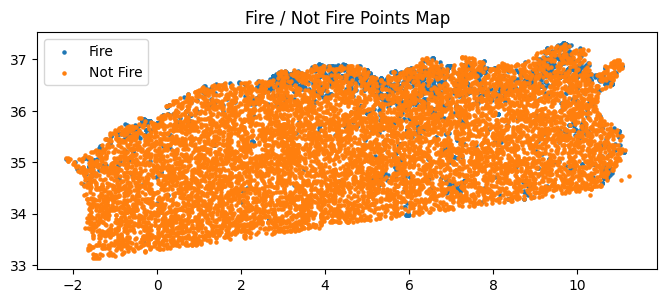

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Séparer fire et not fire
points_gdf[points_gdf["fire"] == 1].plot(
    ax=ax,
    markersize=5,
    label="Fire"
)

points_gdf[points_gdf["fire"] == 0].plot(
    ax=ax,
    markersize=5,
    label="Not Fire"
)

ax.set_title("Fire / Not Fire Points Map")
ax.legend()
plt.show()

